In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import numpy as np
import xarray as xr
import dustmaps.bayestar
from astropy.coordinates import SkyCoord
from astropy import units as u
import healpy as hp
import h5py
from astropy.io import fits, ascii
from tqdm import tqdm
from scipy.interpolate import interp1d
from astropy.modeling import models, fitting
from astropy.table import QTable, Table, Column, vstack

from specutils import Spectrum1D, SpectralRegion
from specutils.fitting import find_lines_threshold, find_lines_derivative
from specutils.fitting import estimate_line_parameters
from specutils.manipulation import extract_region
from specutils.manipulation import noise_region_uncertainty
import specutils

import pandas as pd

from astropy.modeling.fitting import LevMarLSQFitter
fit = LevMarLSQFitter()

# How to decimate a signal

from scipy.signal import find_peaks, peak_widths, decimate

# Open the KT1 G&T Map
ds_disk = xr.open_dataset('../maps/kinematic_sets.nc')

from lmfit import Model, minimize, Parameters, report_fit
from lmfit.models import GaussianModel, PolynomialModel

In [3]:
# import OHfunc.py
import OHfunc as OH

/tmp/ipykernel_275/1318658008.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(6,6))


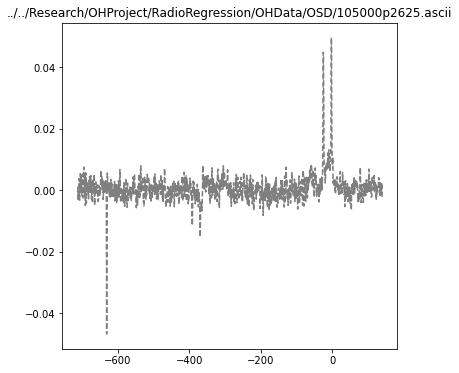

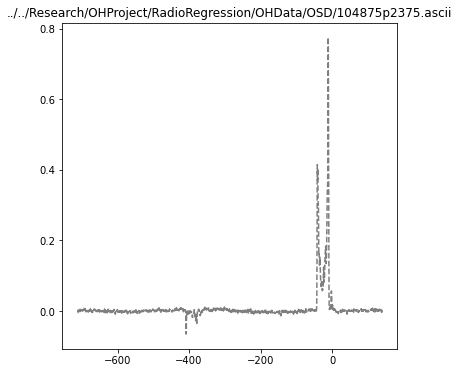

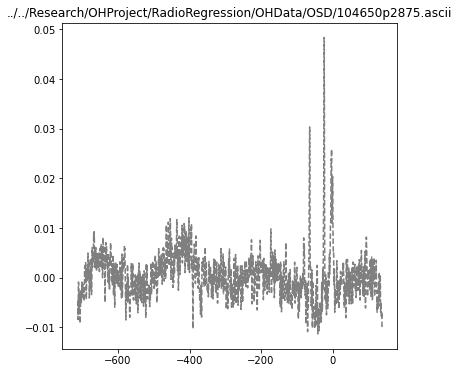

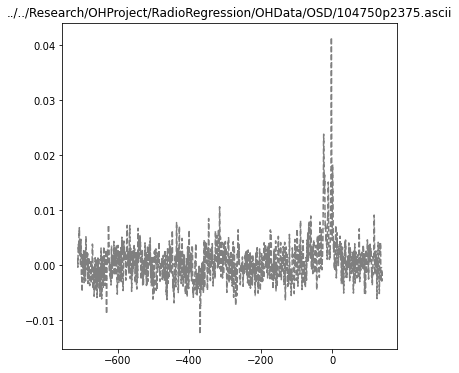

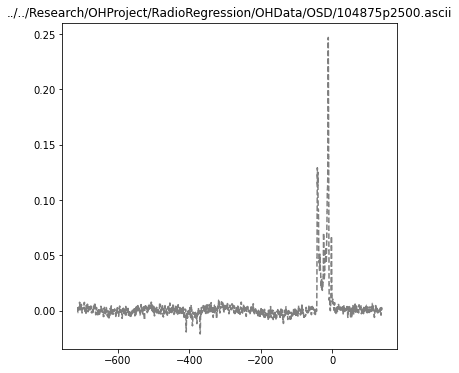

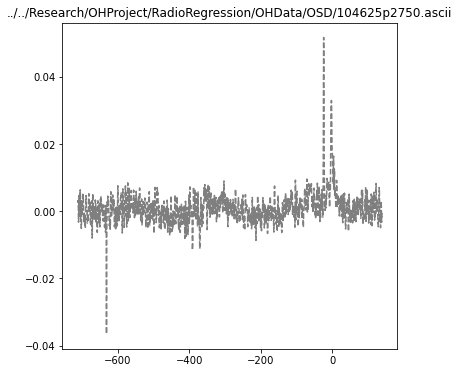

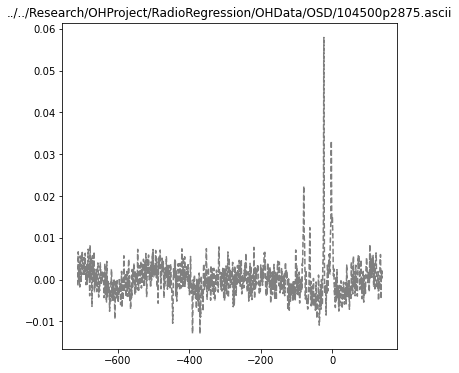

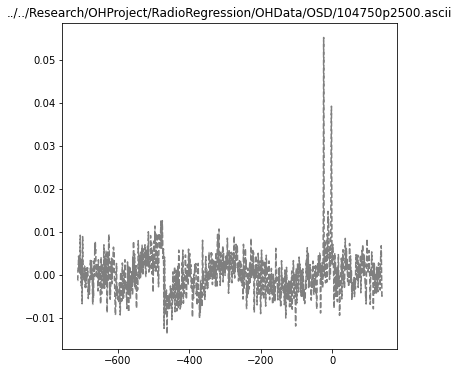

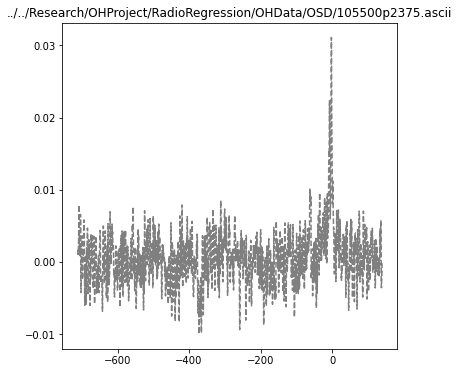

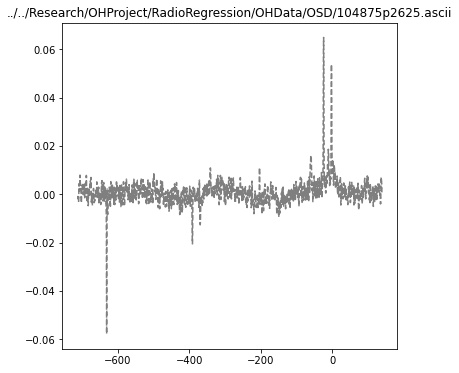

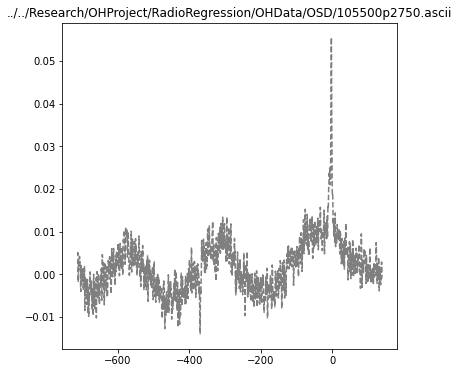

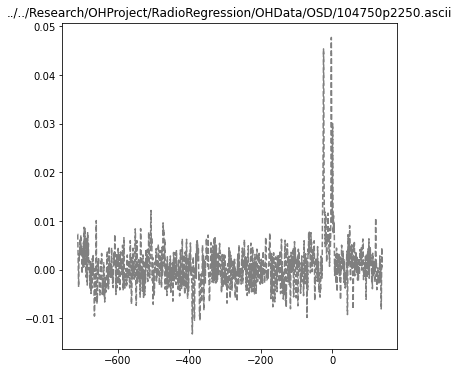

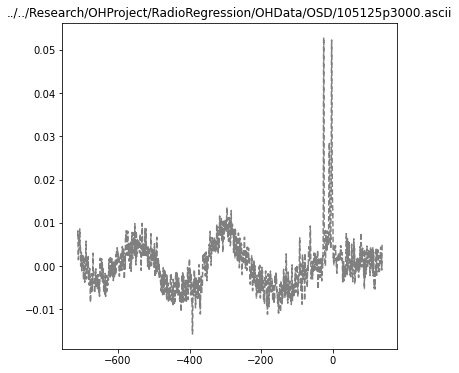

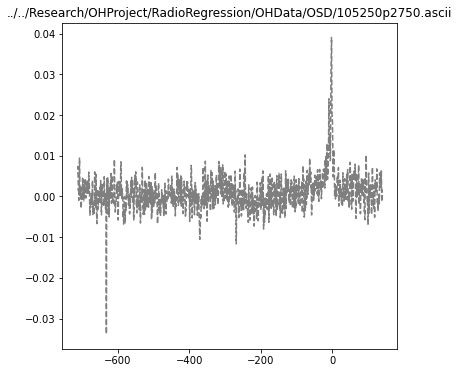

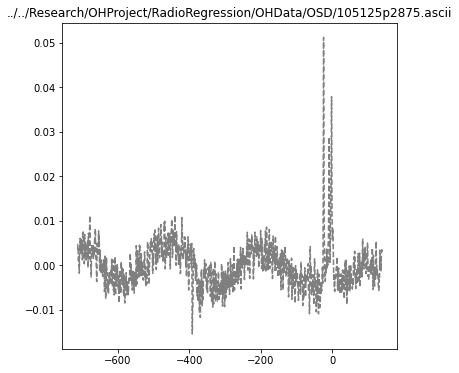

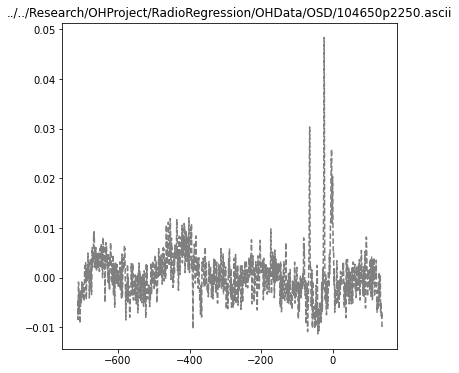

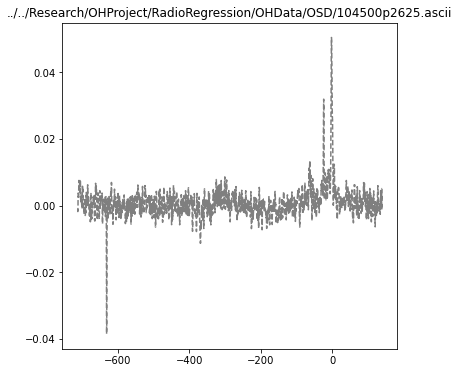

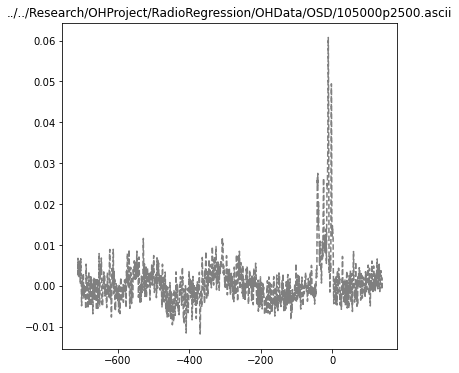

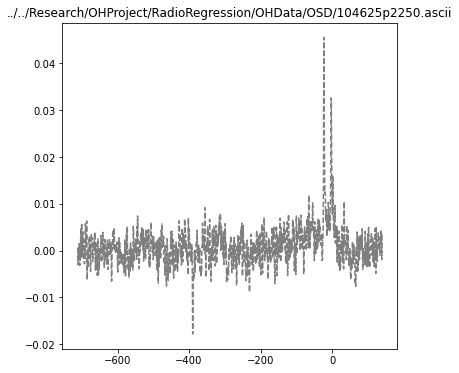

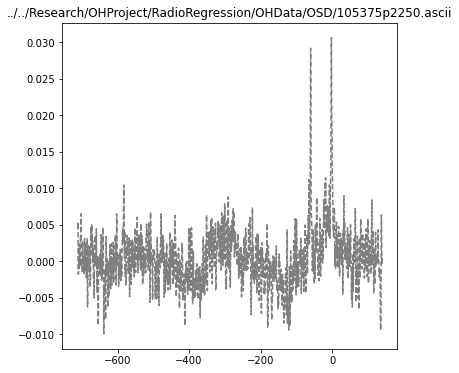

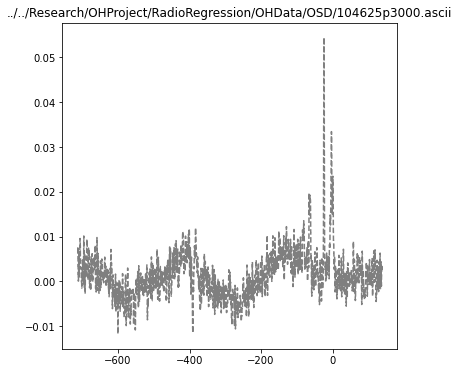

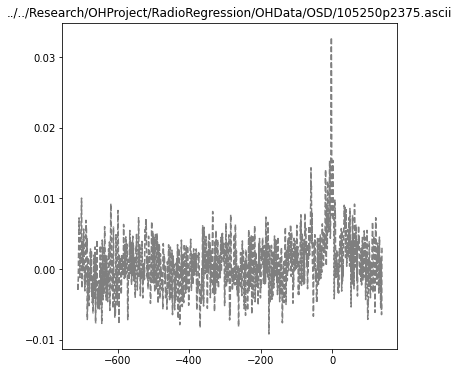

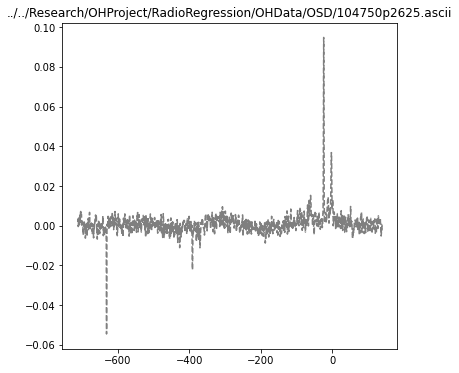

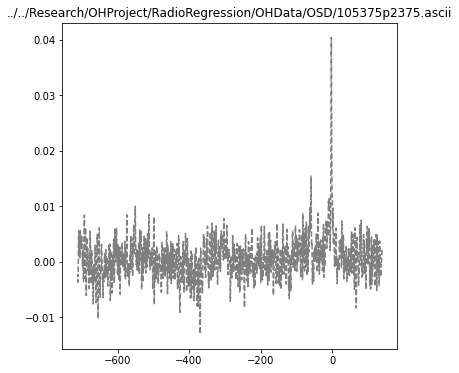

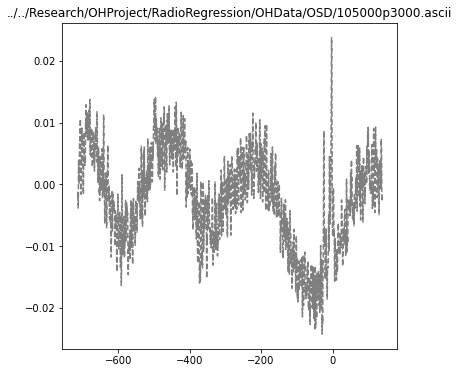

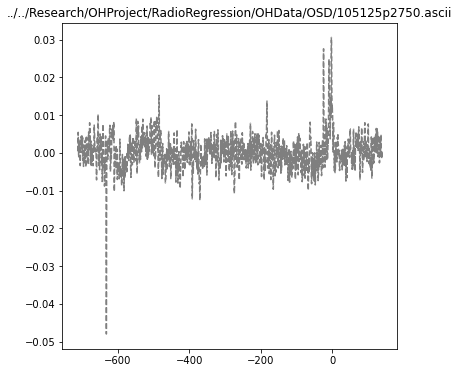

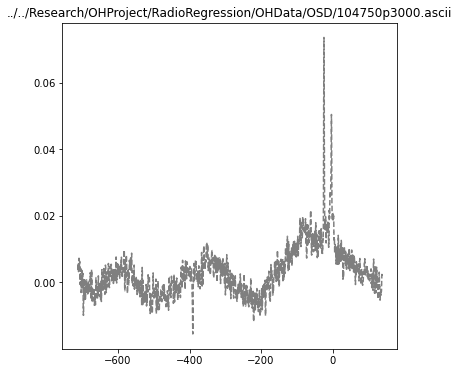

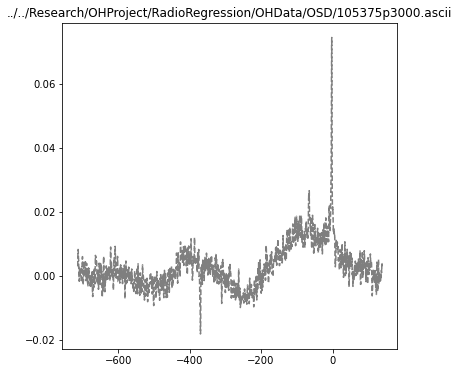

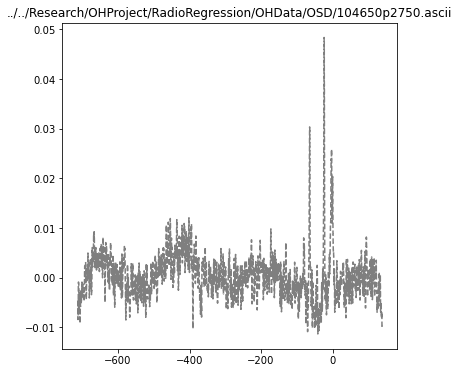

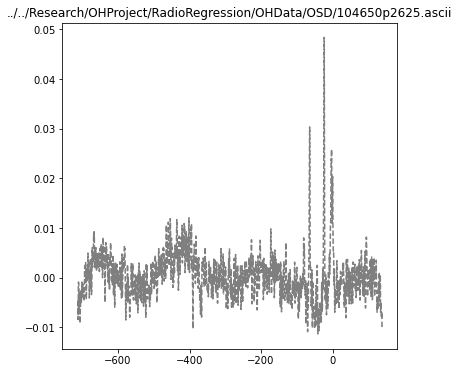

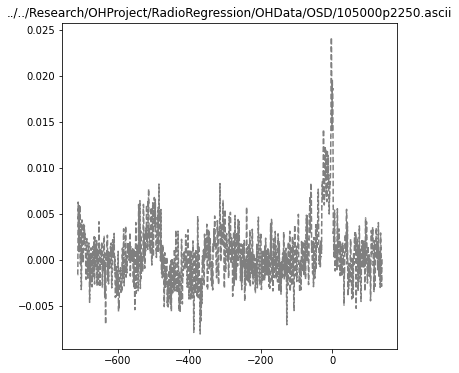

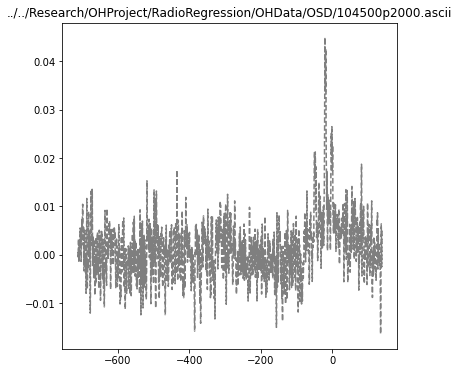

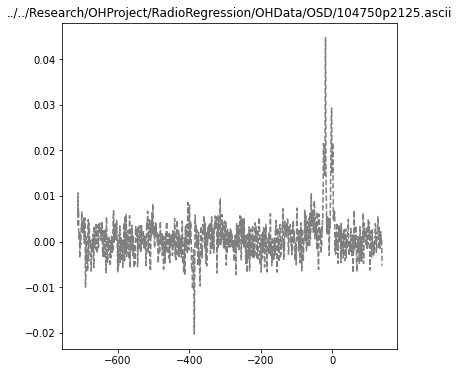

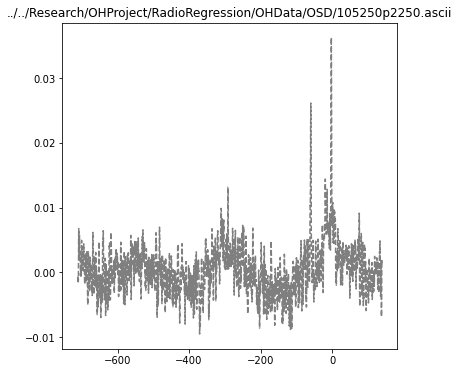

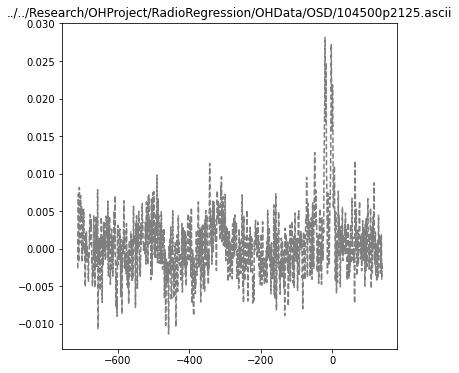

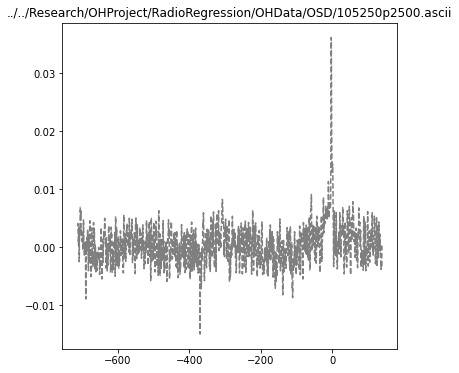

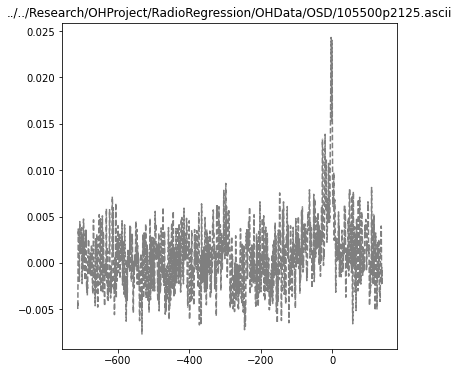

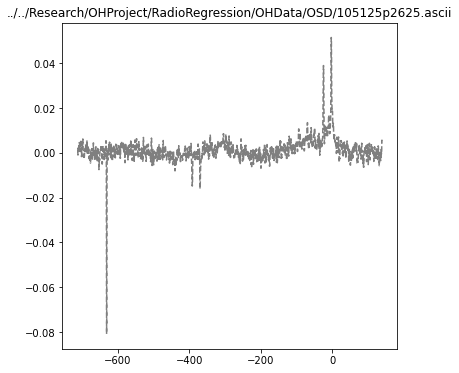

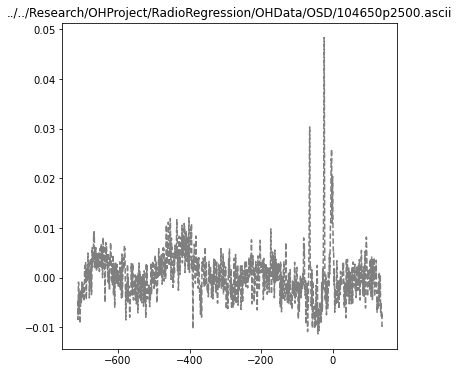

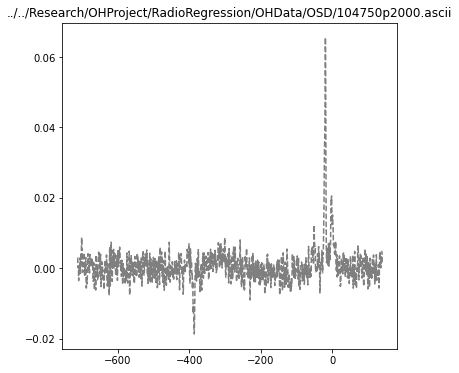

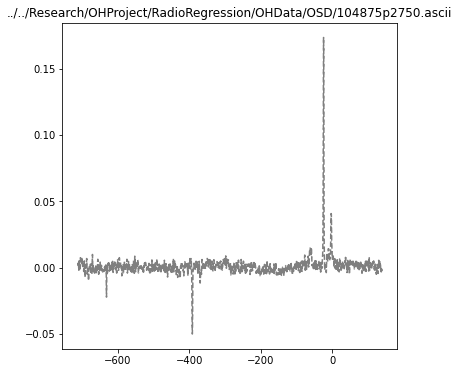

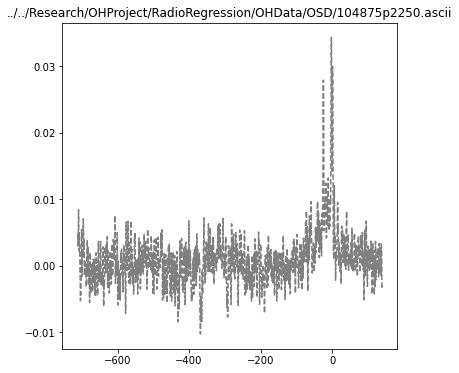

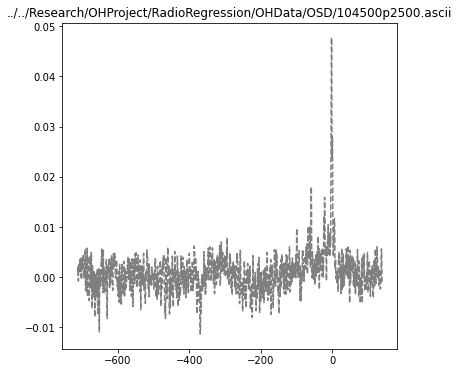

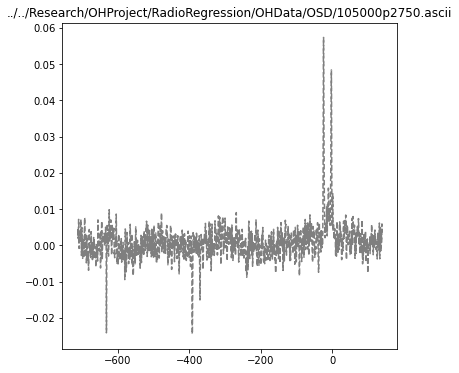

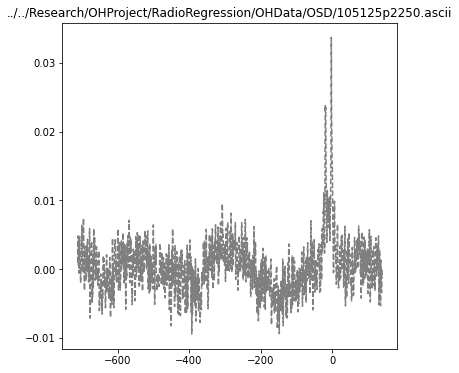

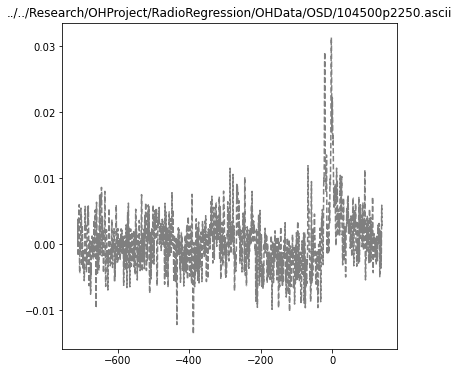

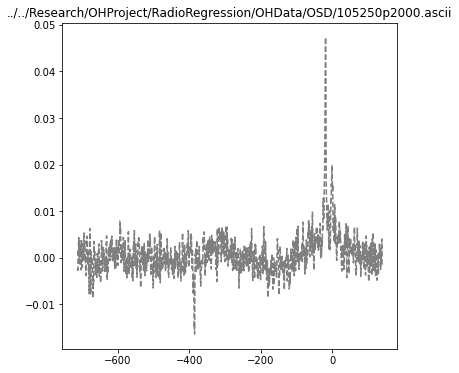

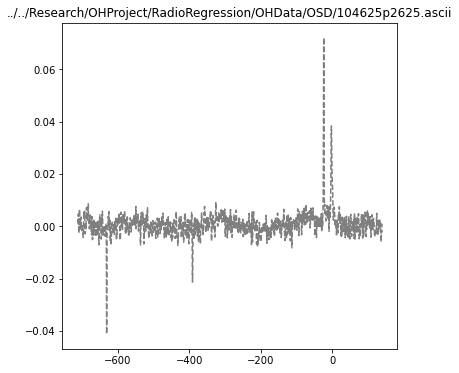

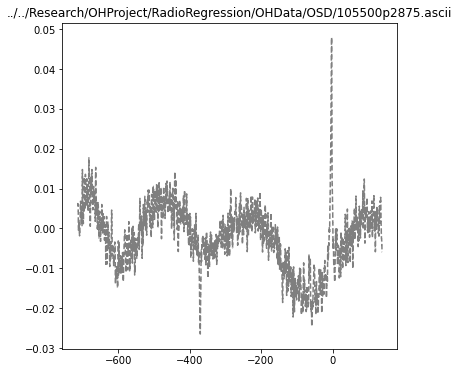

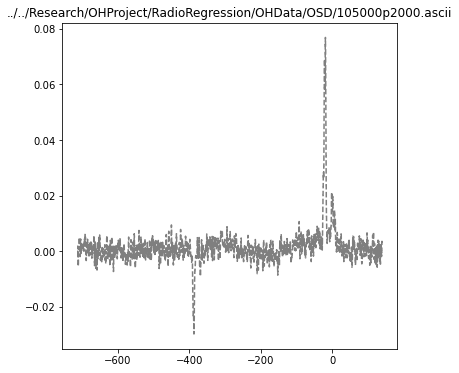

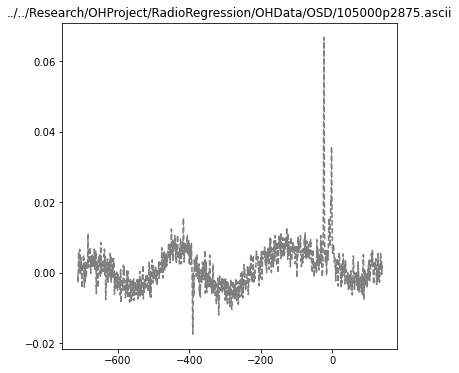

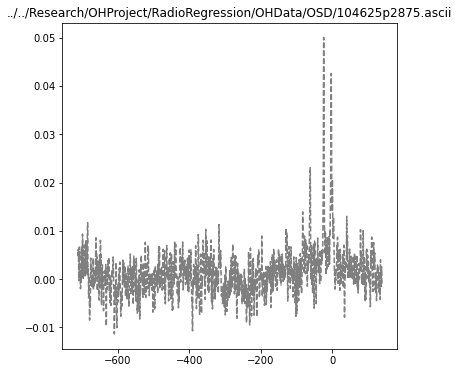

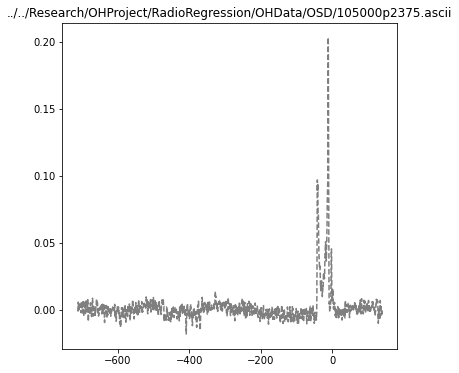

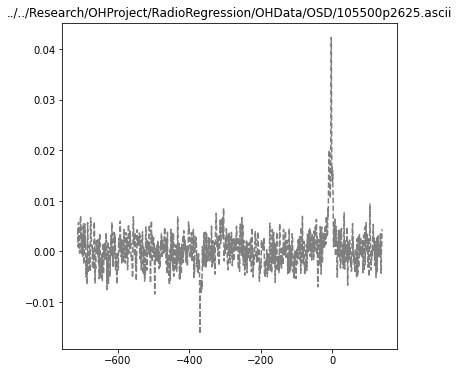

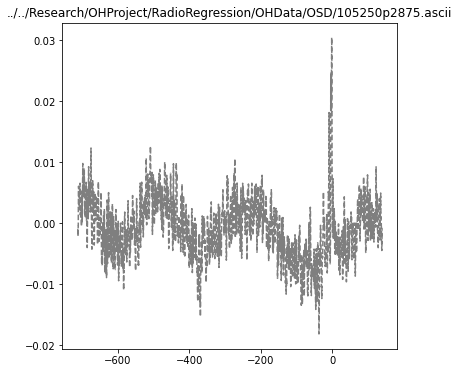

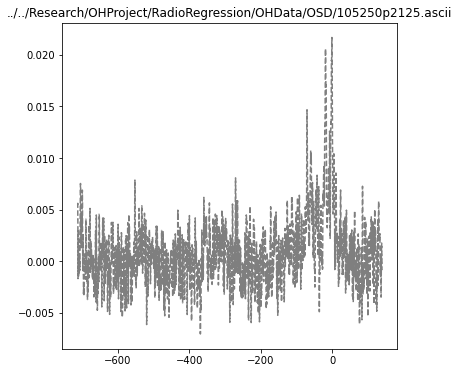

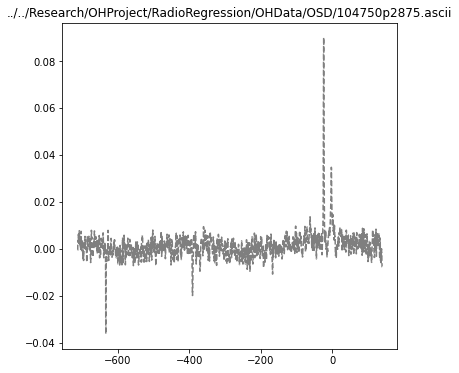

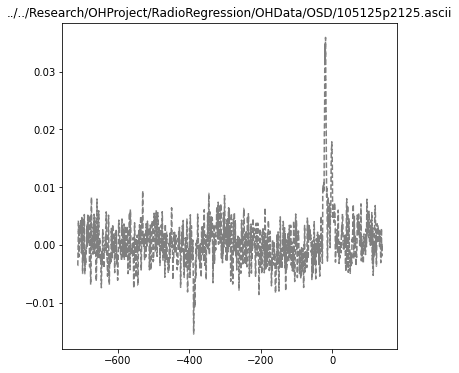

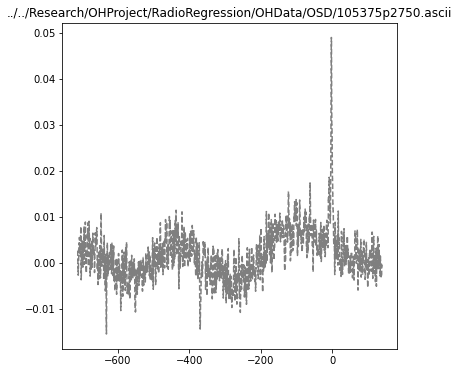

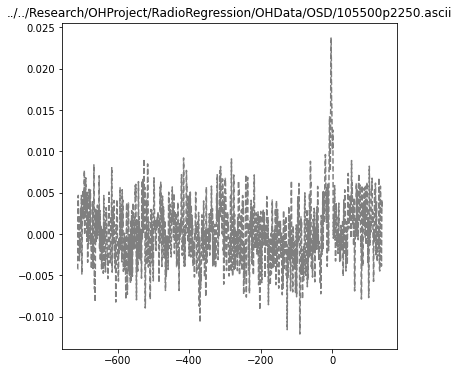

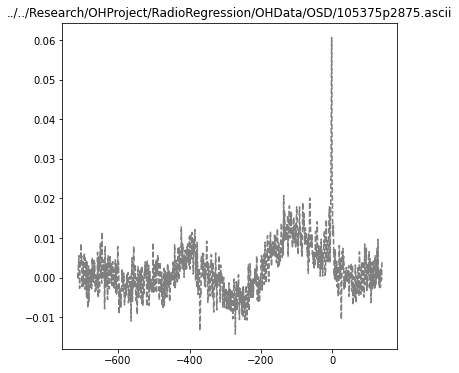

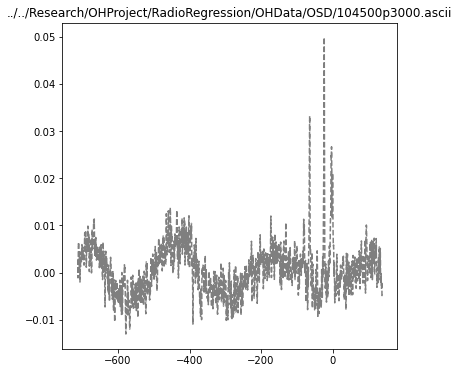

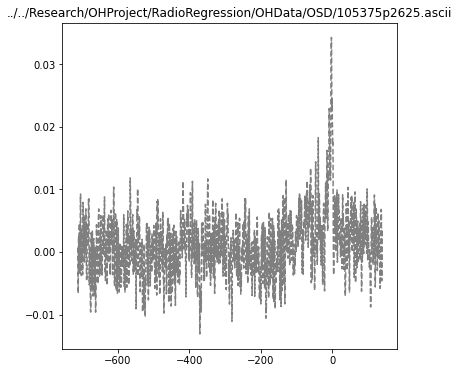

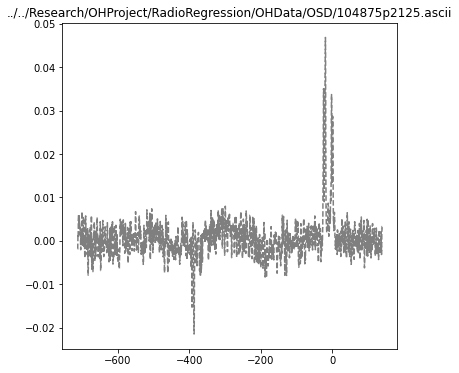

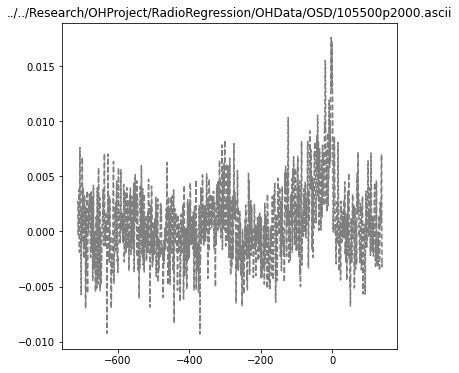

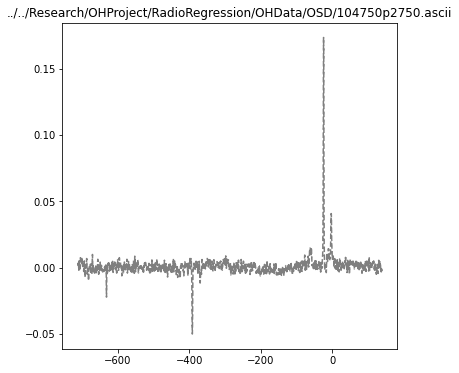

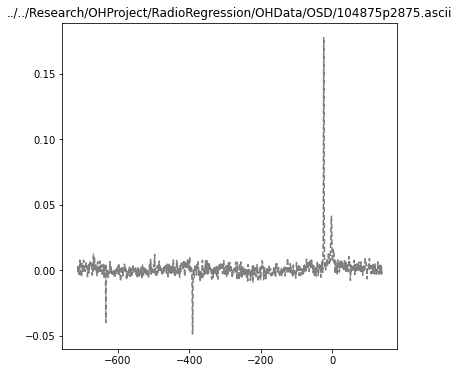

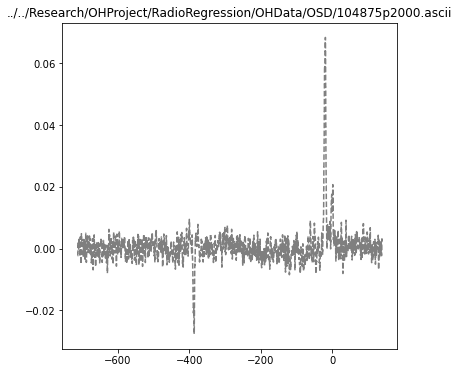

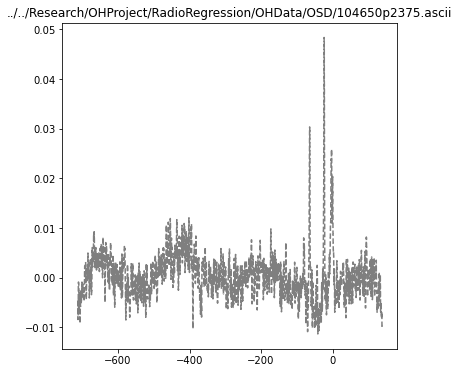

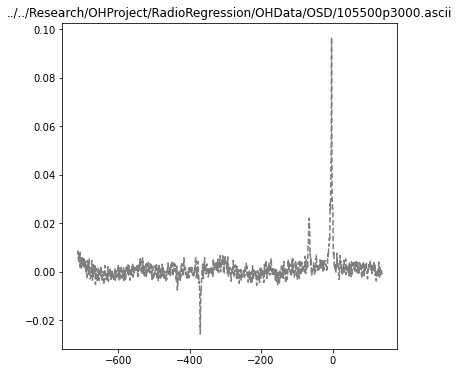

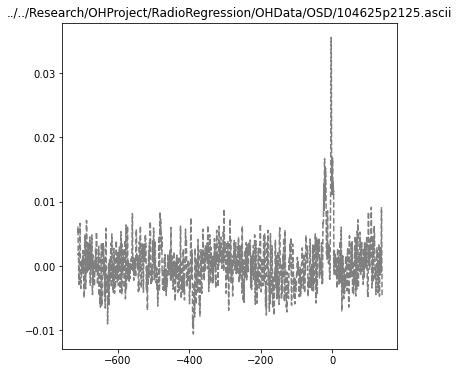

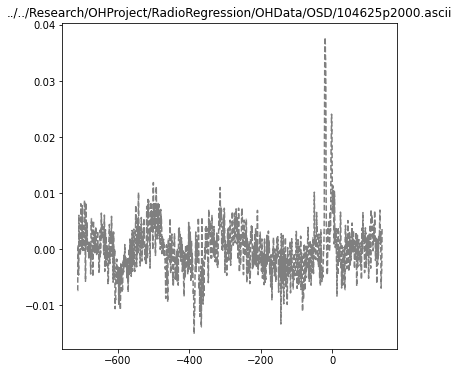

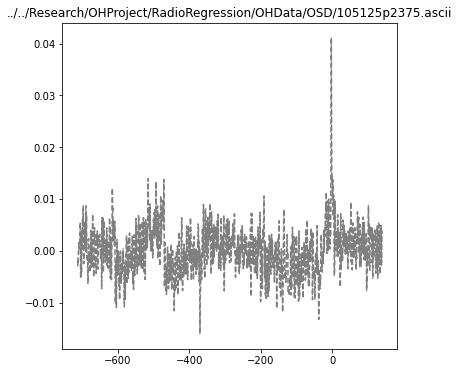

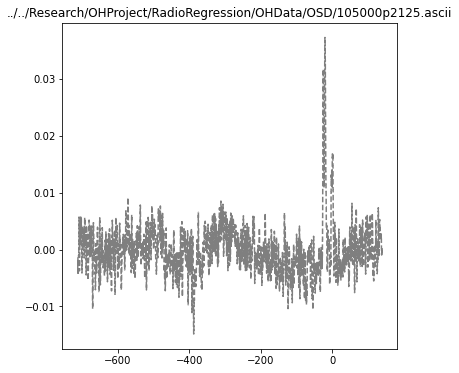

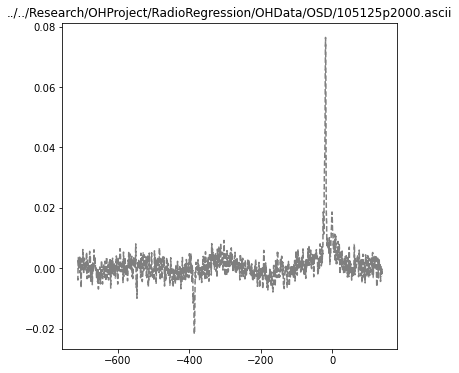

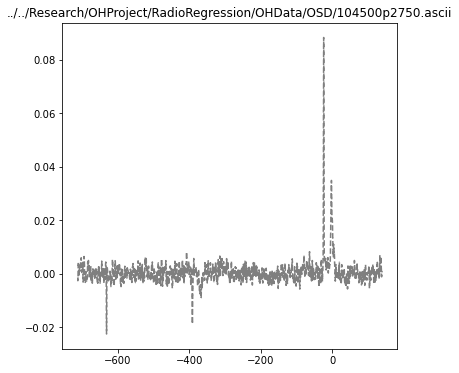

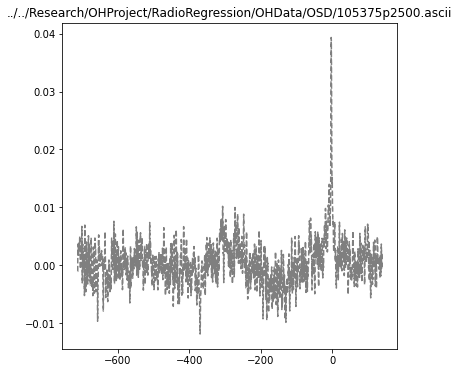

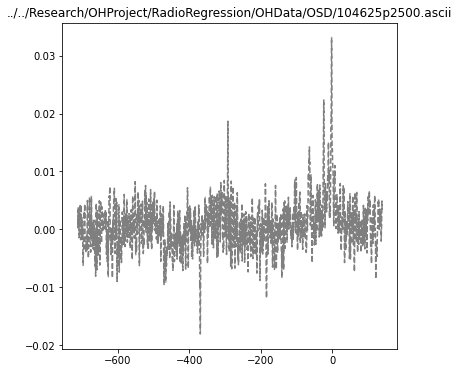

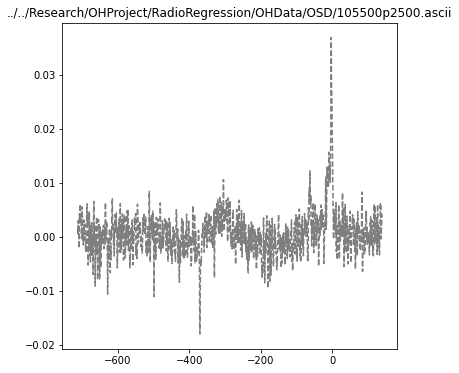

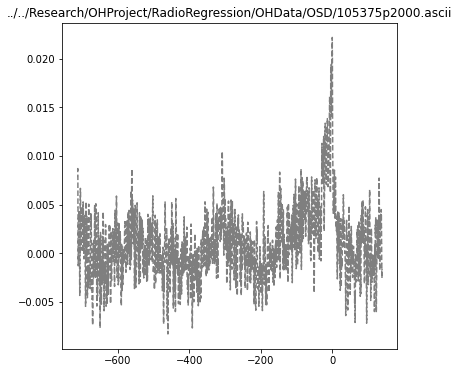

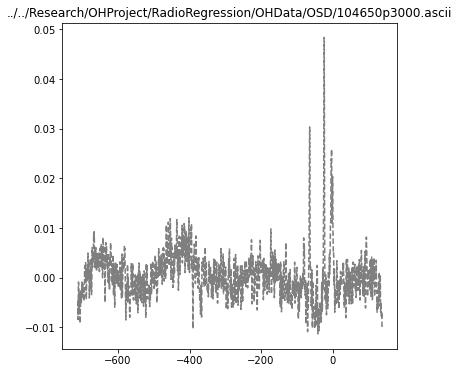

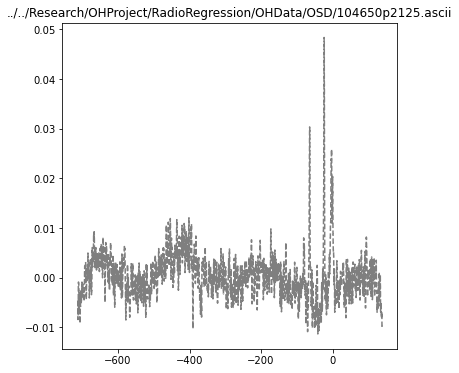

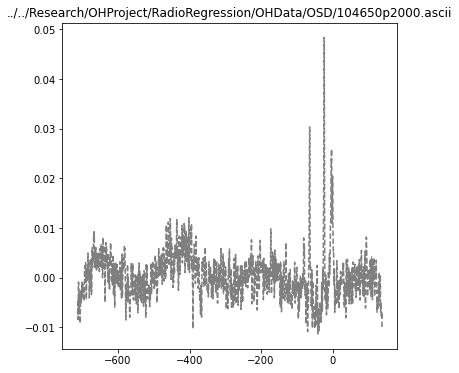

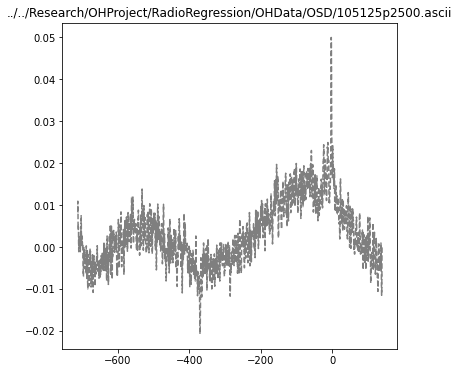

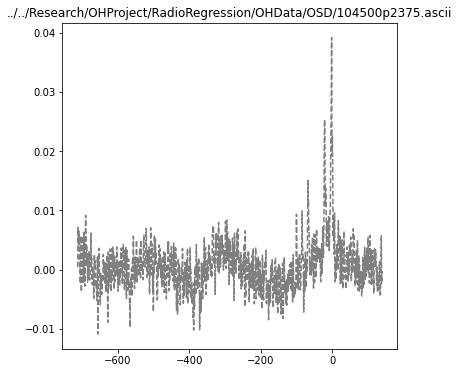

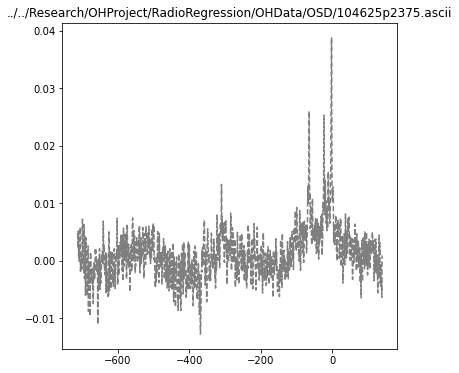

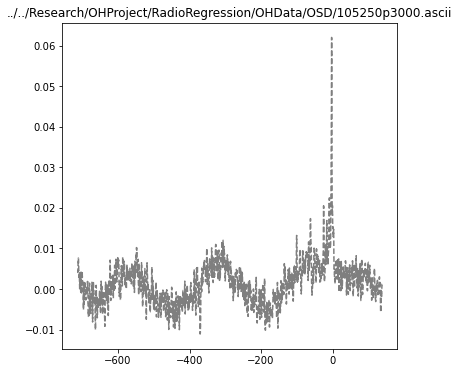

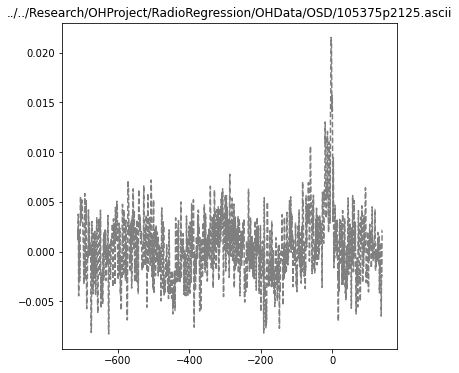

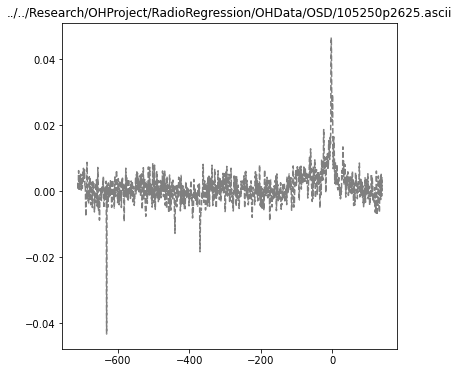

In [4]:
# Average all of the OSD:

from astropy.io import ascii
import glob

skip = ["../../Research/OHProject/RadioRegression/OHData/OSD/104875p2375.ascii",
       "../../Research/OHProject/RadioRegression/OHData/OSD/104875p2500.ascii",
       "../../Research/OHProject/RadioRegression/OHData/OSD/105500p2750.ascii",
       "../../Research/OHProject/RadioRegression/OHData/OSD/105125p3000.ascii",
       "../../Research/OHProject/RadioRegression/OHData/OSD/105125p2875.ascii",
       "../../Research/OHProject/RadioRegression/OHData/OSD/104625p3000.ascii",
       "../../Research/OHProject/RadioRegression/OHData/OSD/105000p3000.ascii",
       "../../Research/OHProject/RadioRegression/OHData/OSD/104750p3000.ascii",
       "../../Research/OHProject/RadioRegression/OHData/OSD/105375p3000.ascii",
       "../../Research/OHProject/RadioRegression/OHData/OSD/105500p2875.ascii",
       "../../Research/OHProject/RadioRegression/OHData/OSD/105000p3275.ascii",
       "../../Research/OHProject/RadioRegression/OHData/OSD/104875p3000.ascii"]

skip = ["../../Research/OHProject/RadioRegression/OHData/OSD/104875p3000.ascii"]

grandAverage = Table()
#grandAverage['Vel. (km/s)'] = Vel
b = 0

for i in glob.glob("../../Research/OHProject/RadioRegression/OHData/OSD/*p*"):
    if i in skip:
        continue
    b += 1
    fig, ax = plt.subplots(figsize=(6,6))
    OHdata = ascii.read(i, data_start=1500, data_end=6100, names=['Vel. (km/s)', 'Ta (K)'])
    Ta = OHdata['Ta (K)']
    Vel = OHdata['Vel. (km/s)']
    ax.set_title(i)
    ax.step(Vel, Ta, color='k', alpha=0.5, ls='dashed', where='mid')
    grandAverage.add_column(Ta, name=str(b))
    

In [5]:
gA = grandAverage.to_pandas()

In [6]:
gA

1         2         3         4         5         6  \
0     1.052900e-03 -0.004901 -0.004518  0.001199 -0.001787  0.002985   
1     6.115000e-04 -0.003762 -0.005475  0.000211 -0.000140  0.003163   
2    -1.000000e-07 -0.002238 -0.006638 -0.000403  0.001754  0.002983   
3    -9.167000e-04 -0.000925 -0.007655 -0.000345  0.003433  0.002767   
4    -1.992100e-03 -0.000101 -0.008302  0.000297  0.004338  0.002723   
...            ...       ...       ...       ...       ...       ...   
4595  1.881500e-03 -0.000476 -0.007153 -0.002914  0.000169 -0.000937   
4596  5.934000e-04  0.001788 -0.007887 -0.002609  0.000590 -0.000629   
4597 -8.887000e-04  0.003507 -0.008808 -0.002005  0.001203 -0.000759   
4598 -1.943000e-03  0.004274 -0.009635 -0.001240  0.001747 -0.001156   
4599 -2.277400e-03  0.004225 -0.010115 -0.000445  0.002108 -0.001690   

             7         8         9        10  ...        80        81  \
0    -0.001383 -0.001336  0.001651 -0.001825  ...  0.008502 -0.004518   
1    -0.000074 -0.001133  0.001546 -0.001902  ...  0.008697 -0.005475   
2     0.001021 -0.000485  0.001516 -0.001820  ...  0.007893 -0.006638   
3     0.001911  0.000360  0.001371 -0.001499  ...  0.006470 -0.007655   
4     0.002898  0.000982  0.001151 -0.001111  ...  0.004762 -0.008302   
...        ...       ...       ...       ...  ...       ...       ...   
4595  0.000642 -0.003136 -0.001888  0.002313  ... -0.002034 -0.007153   
4596  0.000335 -0.004228 -0.001653  0.001295  ... -0.002570 -0.007887   
4597  0.000529 -0.005045 -0.001300  0.000626  ... -0.002563 -0.008808   
4598  0.001195 -0.005298 -0.000776  0.000356  ... -0.002122 -0.009635   
4599  0.002002 -0.004803 -0.000154  0.000190  ... -0.001535 -0.010115   

            82        83        84        85        86        87        88  \
0    -0.004518 -0.004518  0.008226  0.000398  0.004793  0.004475  0.002071   
1    -0.005475 -0.005475  0.010217  0.002346  0.004020  0.004204  0.001831   
2    -0.006638 -0.006638  0.010908  0.004261  0.003249  0.004105  0.001510   
3    -0.007655 -0.007655  0.010294  0.005838  0.002579  0.004325  0.001247   
4    -0.008302 -0.008302  0.008733  0.006828  0.002177  0.005013  0.001257   
...        ...       ...       ...       ...       ...       ...       ...   
4595 -0.007153 -0.007153 -0.009411 -0.002049 -0.006066  0.000111 -0.002212   
4596 -0.007887 -0.007887 -0.007073 -0.001508 -0.004689  0.000542 -0.001517   
4597 -0.008808 -0.008808 -0.004328 -0.001006 -0.002585  0.000886 -0.000389   
4598 -0.009635 -0.009635 -0.001725 -0.000581 -0.000462  0.001101  0.000939   
4599 -0.010115 -0.010115  0.000274 -0.000208  0.000941  0.001203  0.002152   

            89  
0     0.002553  
1     0.002391  
2     0.002098  
3     0.001865  
4     0.001666  
...        ...  
4595  0.004154  
4596  0.003452  
4597  0.001956  
4598  0.000157  
4599 -0.001576  

[4600 rows x 89 columns]

In [7]:
#gA.pop('Vel. (km/s)')
average = gA.mean(axis=1)

In [8]:
gA['Average'] = average

(-800.0, 100.0)

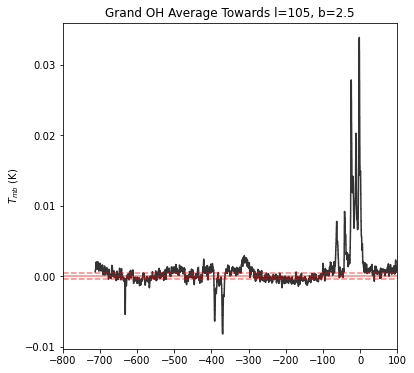

In [14]:
fig, ax = plt.subplots(figsize=(6,6))
ax.step(Vel, gA['Average'], color='k', alpha=0.8, ls='solid')
ax.axhline(0, color='r', alpha=0.5)
ax.axhline(0.0004, color='r', ls='dashed', alpha=0.5)
ax.axhline(-0.0004, color='r', ls='dashed', alpha=0.5)
ax.set_ylabel(r'$T_{mb}$ (K)')
ax.set_title('Grand OH Average Towards l=105, b=2.5')
ax.set_xlim([-800, 100])

In [188]:
# Let's fit a polynomial to the baseline region:

In [53]:
# Fitting the background:
mod = PolynomialModel(degree=2)

# Baseline regions:
igoodNeg = list(np.where((Vel >= -280) & (Vel <= -150))[0])
igoodPos = list(np.where((Vel >= 30) & (Vel <= 100))[0])

igood = igoodNeg + igoodPos

# Do the fitting:
pars = mod.guess(gA['Average'][igood], x=Vel[igood])
out = mod.fit(gA['Average'][igood], pars, x=Vel[igood])

In [54]:
print(out.fit_report(min_correl=0.3))

[[Model]]
    Model(polynomial)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 5
    # data points      = 1080
    # variables        = 3
    chi-square         = 1.7787e-04
    reduced chi-square = 1.6515e-07
    Akaike info crit   = -16862.6974
    Bayesian info crit = -16847.7433
    R-squared          = 0.64928360
[[Variables]]
    c0:  9.2190e-05 +/- 2.4528e-05 (26.61%) (init = 9.21901e-05)
    c1:  8.1848e-06 +/- 2.4469e-07 (2.99%) (init = 8.184779e-06)
    c2:  2.7950e-08 +/- 1.3816e-09 (4.94%) (init = 2.794974e-08)
[[Correlations]] (unreported correlations are < 0.300)
    C(c1, c2) = +0.9300
    C(c0, c2) = -0.7496
    C(c0, c1) = -0.5393


(-300.0, 100.0)

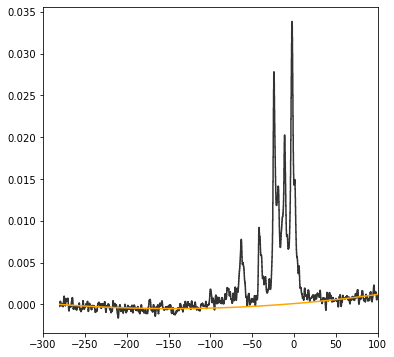

In [55]:
x = np.linspace(-280, 100, 2052)
y_eval = mod.eval(pars, x=x)

igood = list(np.where((Vel >= -280) & (Vel <= 100))[0])

fig, ax = plt.subplots(figsize=(6,6))
ax.step(Vel[igood], gA['Average'][igood], color='k', alpha=0.8, ls='solid')

plt.plot(x, y_eval, 'orange')
ax.set_xlim([-300, 100])

In [56]:
len(Vel[igood]) # How many channels do we have?

2052

In [69]:
Vel[1] - Vel[0] # What is the Velocity Resolution?

0.18517469053279

In [70]:
# Perform Baseline subtraction (subtract the background):
x = np.linspace(-280, 100, 2052)
y_eval = mod.eval(pars, x=x)

igood = list(np.where((Vel >= -280) & (Vel <= 100))[0])

fitted_y = gA['Average'][igood]-y_eval

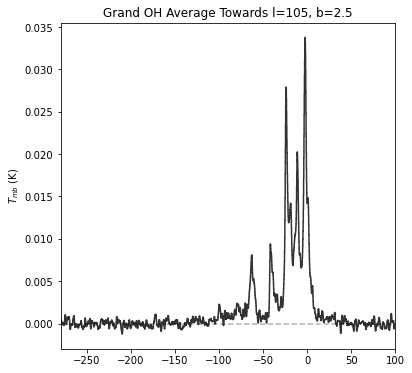

In [72]:
# Plot the results:
fig, ax = plt.subplots(figsize=(6,6))
ax.step(Vel[igood], fitted_y, color='k', alpha=0.8, ls='solid')
ax.axhline(0, ls='dashed', alpha=0.3, color='k')
ax.set_ylabel(r'$T_{mb}$ (K)')
ax.set_title('Grand OH Average Towards l=105, b=2.5')
#ax.axhline(0.00038, ls='dashed', alpha=0.3, color='k')
#ax.axhline(-0.00038, ls='dashed', alpha=0.3, color='k')

#plt.plot(x, y_eval, 'orange')
ax.set_xlim([-280, 100])

fig.savefig('GrandOSDAverage.png', format='png')
fig.savefig('GrandOSDAverage.pdf', format='pdf')

In [60]:
# FIT A GAUSSIAN HERE:

In [67]:
# Checking the noise in the baseline regions:
igood = list(np.where((Vel >= -250) & (Vel <= -160))[0])
np.std(fitted_y[igood])

0.00038176226889354443

In [ ]:
# DO INTEGRALS under the gaussians.

In [ ]:
# gaussian linewidth:
igood = list(np.where((Vel >= peak_center-FWHM) & (Vel <= peak_center + FWHM))[0])

np.sum(y[igood])*(Vel[1] - Vel[0])

In [52]:
# Do the same thing for the HI, CO
# Plot the 3D dust data.